<a href="https://colab.research.google.com/github/vishnuvardhanreddychallapalli/Named-Entity-Recognition/blob/master/BertNer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
def get_data_and_labels(filename,is_train):
    my_data=[]
    my_labels=[]
    curr_label=[]
    curr_sent=[]
    with open(filename) as f:
        for eachline in f:
            if len(eachline.strip())==0:
                #print("length of line ={} and sent={}".format(len(eachline),eachline))
                if(is_train):
                    my_data.append(" ".join(curr_sent))
                    my_labels.append(curr_label)
                else:
                    my_data.append(" ".join(curr_sent))
                curr_label=[]
                curr_sent=[]
            else:
                my_keys=eachline.strip().split("\t")
                #print(my_keys)
                if(is_train):
                    curr_sent.append(my_keys[0])
                    curr_label.append(my_keys[1])
                else:
                    curr_sent.append(my_keys[0])
    if is_train:
        return my_data,my_labels
    else:
        return my_data

In [0]:
train_data,train_labels=get_data_and_labels('train.txt',True)

In [0]:
test_data=get_data_and_labels('test.txt',False)

In [0]:
len(train_data),len(train_labels)

(3395, 3395)

In [0]:
len(test_data)

1287

In [0]:
counter=dict()
for each_list in train_labels:
  curr_list=each_list
  for each_label in each_list:
    if counter.get(each_label)==None:
      counter[each_label]=1
    else:
      counter[each_label]+=1
counter

{'B-corporation': 221,
 'B-creative-work': 140,
 'B-group': 264,
 'B-location': 548,
 'B-person': 660,
 'B-product': 142,
 'I-corporation': 46,
 'I-creative-work': 206,
 'I-group': 150,
 'I-location': 245,
 'I-person': 335,
 'I-product': 203,
 'O': 59570}

In [0]:
import numpy as np
total=0
for val in counter.values():
  total+=val
total

62730

In [0]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

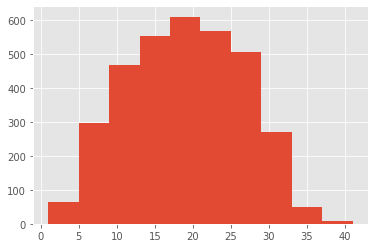

In [0]:
plt.hist([len(s.split(" ")) for s in train_data])
plt.show()

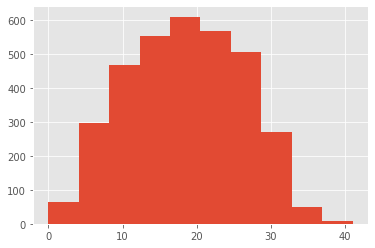

In [0]:
plt.hist([len(s) for s in train_labels])
plt.show()

In [0]:
for i in range(len(train_data)):
  if len(train_data[i].split(" "))!=len(train_labels[i]):
      print(train_data[i])
      print(train_labels[i])


[]


In [0]:
maxlen = max([len(s.split(" ")) for s in train_data])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 41


In [0]:
max_len=-1
max_sent=""
for eachsent in train_data:
    if len(eachsent.split(" "))>max_len:
        max_len=len(eachsent.split(" "))
        max_sent=eachsent

In [0]:
max_len,max_sent

(41,
 're : re : re : re : re : re : re : re : re : re : re : re : Esther Sikkimese is now following me on Twitter ! http://t.co/Z58brwgxFp Thanks a bunch ! 103 January ...')

In [0]:
def get_unique_tokens(data):
    unique_words=set()
    for each_data_point in data:
        #print(each_data_point)
        for each_word in each_data_point.split(" "):
            unique_words.add(each_word)
    return list(unique_words)

In [0]:
def get_unique_labels(data):
    unique_labels=set()
    for each_label in data:
      curr_label=each_label
      for each_label_point in curr_label:
          unique_labels.add(each_label_point)
    return list(unique_labels)

In [0]:
unique_train_tokens=get_unique_tokens(train_data)

In [0]:
unique_train_labels=get_unique_labels(train_labels)

In [0]:
len(unique_train_tokens),len(unique_train_labels)

(14879, 13)

In [0]:
unique_train_labels

['B-person',
 'B-product',
 'B-location',
 'I-creative-work',
 'B-corporation',
 'I-product',
 'O',
 'I-corporation',
 'I-person',
 'I-location',
 'I-group',
 'B-group',
 'B-creative-work']

In [0]:
dict_of_word2idx = {w: i for i, w in enumerate(unique_train_tokens)}
dict_of_tag2idx = {t: i for i, t in enumerate(unique_train_labels)}
dict_of_idx2word= {i:w for i,w in enumerate(unique_train_tokens)}
dict_of_idx2tag=  {i:t for i,t in enumerate(unique_train_labels)}

In [0]:
dict_of_tag2idx

{'B-corporation': 4,
 'B-creative-work': 12,
 'B-group': 11,
 'B-location': 2,
 'B-person': 0,
 'B-product': 1,
 'I-corporation': 7,
 'I-creative-work': 3,
 'I-group': 10,
 'I-location': 9,
 'I-person': 8,
 'I-product': 5,
 'O': 6}

In [0]:
total_unique_words=len(dict_of_word2idx)
dict_of_word2idx['NA']=total_unique_words
dict_of_idx2word[total_unique_words]='NA'

In [0]:
len(dict_of_word2idx),len(dict_of_idx2word)

(14880, 14880)

In [0]:
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
!pip install pytorch-pretrained-bert
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

Using TensorFlow backend.


In [0]:
MAX_LEN =max_len
bs = 32

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [0]:
n_gpu

1

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_data]
print(tokenized_texts[0])

['@', 'paul', '##walk', 'it', "'", 's', 'the', 'view', 'from', 'where', 'i', "'", 'm', 'living', 'for', 'two', 'weeks', '.', 'empire', 'state', 'building', '=', 'es', '##b', '.', 'pretty', 'bad', 'storm', 'here', 'last', 'evening', '.']


In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
input_ids.shape

(3395, 41)

In [0]:
input_ids[0]

array([ 1030,  2703, 17122,  2009,  1005,  1055,  1996,  3193,  2013,
        2073,  1045,  1005,  1049,  2542,  2005,  2048,  3134,  1012,
        3400,  2110,  2311,  1027,  9686,  2497,  1012,  3492,  2919,
        4040,  2182,  2197,  3944,  1012,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [0]:
tags = pad_sequences([[dict_of_tag2idx[l] if dict_of_tag2idx.get(l) !=None else dict_of_tag2idx['NA'] for l in lab] for lab in train_labels],
                     maxlen=MAX_LEN, value=dict_of_tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [0]:
dict_of_tag2idx

{'B-corporation': 4,
 'B-creative-work': 12,
 'B-group': 11,
 'B-location': 2,
 'B-person': 0,
 'B-product': 1,
 'I-corporation': 7,
 'I-creative-work': 3,
 'I-group': 10,
 'I-location': 9,
 'I-person': 8,
 'I-product': 5,
 'O': 6}

In [0]:
tags[0]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 9, 9, 6, 2, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

In [0]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [0]:
input_ids[0]

array([ 1030,  2703, 17122,  2009,  1005,  1055,  1996,  3193,  2013,
        2073,  1045,  1005,  1049,  2542,  2005,  2048,  3134,  1012,
        3400,  2110,  2311,  1027,  9686,  2497,  1012,  3492,  2919,
        4040,  2182,  2197,  3944,  1012,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)

In [0]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [0]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [0]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(dict_of_tag2idx))

In [0]:
model.cuda();

In [0]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [0]:
!pip install seqeval

In [0]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
from tqdm import tqdm, trange

In [49]:

epochs = 150
max_grad_norm = 0.5

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [unique_train_labels[p_i] for p in predictions for p_i in p]
    valid_tags = [unique_train_labels[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Train loss: 0.2568814486730844


Epoch:   1%|          | 1/150 [00:57<2:22:59, 57.58s/it]

Validation loss: 0.1790371076627211
Validation Accuracy: 0.9762749445676274
F1-Score: 0
Train loss: 0.16283439278292158


Epoch:   1%|▏         | 2/150 [01:55<2:22:23, 57.73s/it]

Validation loss: 0.14851226589896463
Validation Accuracy: 0.9765521064301551
F1-Score: 0
Train loss: 0.1313689424811552


Epoch:   2%|▏         | 3/150 [02:54<2:21:58, 57.95s/it]

Validation loss: 0.13877380097454245
Validation Accuracy: 0.9763026607538802
F1-Score: 0.03404255319148936
Train loss: 0.11061987436066072


Epoch:   3%|▎         | 4/150 [03:52<2:21:17, 58.07s/it]

Validation loss: 0.13792978565801273
Validation Accuracy: 0.9747089800443458
F1-Score: 0.06578947368421054
Train loss: 0.09456535494731118


Epoch:   3%|▎         | 5/150 [04:51<2:20:45, 58.25s/it]

Validation loss: 0.13843102888627487
Validation Accuracy: 0.9764828159645232
F1-Score: 0.10830324909747294
Train loss: 0.08342197865325336


Epoch:   4%|▍         | 6/150 [05:49<2:20:02, 58.35s/it]

Validation loss: 0.13579029860821637
Validation Accuracy: 0.9744318181818182
F1-Score: 0.1529051987767584
Train loss: 0.07242248063751806


Epoch:   5%|▍         | 7/150 [06:48<2:19:01, 58.33s/it]

Validation loss: 0.14166194810108704
Validation Accuracy: 0.9746674057649668
F1-Score: 0.14484679665738162
Train loss: 0.06331663578748703


Epoch:   5%|▌         | 8/150 [07:46<2:18:02, 58.33s/it]

Validation loss: 0.1424813141877001
Validation Accuracy: 0.9726995565410199
F1-Score: 0.1329923273657289
Train loss: 0.058875622208385416


Epoch:   6%|▌         | 9/150 [08:44<2:17:09, 58.37s/it]

Validation loss: 0.15062499181790787
Validation Accuracy: 0.9751940133037695
F1-Score: 0.15384615384615383
Train loss: 0.05214980757834079


Epoch:   7%|▋         | 10/150 [09:43<2:16:10, 58.36s/it]

Validation loss: 0.15043232048099692
Validation Accuracy: 0.9728935698447895
F1-Score: 0.16080402010050251
Train loss: 0.04654768314988663


Epoch:   7%|▋         | 11/150 [10:41<2:15:09, 58.34s/it]

Validation loss: 0.1528525257652456
Validation Accuracy: 0.9758453436807094
F1-Score: 0.16909620991253643
Train loss: 0.03980513080023229


Epoch:   8%|▊         | 12/150 [11:40<2:14:21, 58.42s/it]

Validation loss: 0.16278769143603064
Validation Accuracy: 0.9743625277161864
F1-Score: 0.20212765957446807
Train loss: 0.03655357941655287


Epoch:   9%|▊         | 13/150 [12:38<2:13:08, 58.31s/it]

Validation loss: 0.16256924244490537
Validation Accuracy: 0.9708841463414634
F1-Score: 0.1835294117647059
Train loss: 0.03239744076078447


Epoch:   9%|▉         | 14/150 [13:36<2:12:02, 58.25s/it]

Validation loss: 0.1814309534701434
Validation Accuracy: 0.9751108647450111
F1-Score: 0.18696883852691218
Train loss: 0.02740413131202028


Epoch:  10%|█         | 15/150 [14:34<2:11:12, 58.31s/it]

Validation loss: 0.18304306878284973
Validation Accuracy: 0.9723946784922396
F1-Score: 0.17525773195876287
Train loss: 0.0239017048831253


Epoch:  11%|█         | 16/150 [15:32<2:10:13, 58.31s/it]

Validation loss: 0.19517738913947885
Validation Accuracy: 0.9722006651884701
F1-Score: 0.20772946859903382
Train loss: 0.020783257840472896


Epoch:  11%|█▏        | 17/150 [16:31<2:09:18, 58.33s/it]

Validation loss: 0.1984020254828713
Validation Accuracy: 0.971480044345898
F1-Score: 0.1691542288557214
Train loss: 0.018304544792044908


Epoch:  12%|█▏        | 18/150 [17:29<2:08:23, 58.36s/it]

Validation loss: 0.20460394566709345
Validation Accuracy: 0.9727272727272728
F1-Score: 0.22942643391521197
Train loss: 0.017665240515877183


Epoch:  13%|█▎        | 19/150 [18:27<2:07:19, 58.32s/it]

Validation loss: 0.2184004472060637
Validation Accuracy: 0.9696369179600887
F1-Score: 0.17488789237668162
Train loss: 0.015498408711816106


Epoch:  13%|█▎        | 20/150 [19:26<2:06:30, 58.39s/it]

Validation loss: 0.20640082860534842
Validation Accuracy: 0.9700665188470068
F1-Score: 0.17840375586854462
Train loss: 0.014321829468220434


Epoch:  14%|█▍        | 21/150 [20:24<2:05:12, 58.24s/it]

Validation loss: 0.21672545102509586
Validation Accuracy: 0.9681679600886919
F1-Score: 0.1718061674008811
Train loss: 0.013138124246324878


Epoch:  15%|█▍        | 22/150 [21:22<2:04:22, 58.30s/it]

Validation loss: 0.21501443806019696
Validation Accuracy: 0.9713414634146342
F1-Score: 0.17647058823529413
Train loss: 0.010727945387770887


Epoch:  15%|█▌        | 23/150 [22:21<2:03:26, 58.32s/it]

Validation loss: 0.22398356416008688
Validation Accuracy: 0.9689024390243902
F1-Score: 0.19153674832962136
Train loss: 0.0105529102863026


Epoch:  16%|█▌        | 24/150 [23:19<2:02:28, 58.33s/it]

Validation loss: 0.20627407865090805
Validation Accuracy: 0.9728519955654101
F1-Score: 0.171875
Train loss: 0.009418662903650935


Epoch:  17%|█▋        | 25/150 [24:17<2:01:12, 58.18s/it]

Validation loss: 0.22578957270492206
Validation Accuracy: 0.9728797117516629
F1-Score: 0.20603015075376885
Train loss: 0.0086470936121259


Epoch:  17%|█▋        | 26/150 [25:15<2:00:12, 58.16s/it]

Validation loss: 0.24374755675142462
Validation Accuracy: 0.9676413525498891
F1-Score: 0.1681034482758621
Train loss: 0.008561969907229164


Epoch:  18%|█▊        | 27/150 [26:13<1:59:09, 58.12s/it]

Validation loss: 0.2329248528588902
Validation Accuracy: 0.9716601995565411
F1-Score: 0.1717171717171717
Train loss: 0.007364822795049501


Epoch:  19%|█▊        | 28/150 [27:11<1:58:16, 58.17s/it]

Validation loss: 0.2333314594897357
Validation Accuracy: 0.972020509977827
F1-Score: 0.2079207920792079
Train loss: 0.006706075039195032


Epoch:  19%|█▉        | 29/150 [28:10<1:57:31, 58.28s/it]

Validation loss: 0.2379989962686192
Validation Accuracy: 0.9698170731707315
F1-Score: 0.17011494252873563
Train loss: 0.007426031805152888


Epoch:  20%|██        | 30/150 [29:08<1:56:23, 58.19s/it]

Validation loss: 0.23201302642172034
Validation Accuracy: 0.9723253880266074
F1-Score: 0.17391304347826084
Train loss: 0.005518002653843723


Epoch:  21%|██        | 31/150 [30:06<1:55:11, 58.08s/it]

Validation loss: 0.2512319440191442
Validation Accuracy: 0.9695537694013303
F1-Score: 0.17897091722595077
Train loss: 0.005647276239263495


Epoch:  21%|██▏       | 32/150 [31:04<1:54:19, 58.13s/it]

Validation loss: 0.25145240263505414
Validation Accuracy: 0.971092017738359
F1-Score: 0.1948955916473318
Train loss: 0.005782491590859233


Epoch:  22%|██▏       | 33/150 [32:02<1:53:17, 58.10s/it]

Validation loss: 0.22971427847038617
Validation Accuracy: 0.9727134146341464
F1-Score: 0.18090452261306533
Train loss: 0.004898777576424133


Epoch:  23%|██▎       | 34/150 [33:00<1:52:03, 57.96s/it]

Validation loss: 0.2349076596173373
Validation Accuracy: 0.966019955654102
F1-Score: 0.15918367346938775
Train loss: 0.0046584716146753635


Epoch:  23%|██▎       | 35/150 [33:57<1:50:55, 57.87s/it]

Validation loss: 0.24703576822172513
Validation Accuracy: 0.9731845898004434
F1-Score: 0.16580310880829016
Train loss: 0.004770172157805064


Epoch:  24%|██▍       | 36/150 [34:55<1:50:01, 57.90s/it]

Validation loss: 0.24947453087026422
Validation Accuracy: 0.9708009977827051
F1-Score: 0.1737089201877934
Train loss: 0.00451080590391939


Epoch:  25%|██▍       | 37/150 [35:53<1:48:51, 57.80s/it]

Validation loss: 0.24245220829140057
Validation Accuracy: 0.9717156319290464
F1-Score: 0.19464720194647203
Train loss: 0.0037492500942638194


Epoch:  25%|██▌       | 38/150 [36:51<1:47:52, 57.79s/it]

Validation loss: 0.2529589899561622
Validation Accuracy: 0.9703021064301552
F1-Score: 0.1513002364066194
Train loss: 0.004389068377956089


Epoch:  26%|██▌       | 39/150 [37:48<1:46:58, 57.83s/it]

Validation loss: 0.25434541973200714
Validation Accuracy: 0.970800997782705
F1-Score: 0.19158878504672894
Train loss: 0.0042472129757697985


Epoch:  27%|██▋       | 40/150 [38:47<1:46:13, 57.94s/it]

Validation loss: 0.25194209949536756
Validation Accuracy: 0.9700526607538802
F1-Score: 0.17551963048498845
Train loss: 0.0032038548708139083


Epoch:  27%|██▋       | 41/150 [39:45<1:45:13, 57.93s/it]

Validation loss: 0.25205767154693604
Validation Accuracy: 0.9728658536585367
F1-Score: 0.18952618453865339
Train loss: 0.00304484463352613


Epoch:  28%|██▊       | 42/150 [40:42<1:44:09, 57.87s/it]

Validation loss: 0.2544009644876827
Validation Accuracy: 0.9703575388026607
F1-Score: 0.19413092550790068
Train loss: 0.002994903628329363


Epoch:  29%|██▊       | 43/150 [41:40<1:43:19, 57.94s/it]

Validation loss: 0.2676128839904612
Validation Accuracy: 0.973059866962306
F1-Score: 0.1837270341207349
Train loss: 0.0031879189593079595


Epoch:  29%|██▉       | 44/150 [42:38<1:42:13, 57.86s/it]

Validation loss: 0.25811529430476104
Validation Accuracy: 0.9714661862527717
F1-Score: 0.17821782178217824
Train loss: 0.0031843826152453403


Epoch:  30%|███       | 45/150 [43:36<1:41:02, 57.74s/it]

Validation loss: 0.2673184289173646
Validation Accuracy: 0.9712721729490021
F1-Score: 0.15880893300248142
Train loss: 0.0031467792684149267


Epoch:  31%|███       | 46/150 [44:33<1:40:03, 57.73s/it]

Validation loss: 0.24947072701020676
Validation Accuracy: 0.9698863636363637
F1-Score: 0.15827338129496404
Train loss: 0.003937630542774666


Epoch:  31%|███▏      | 47/150 [45:31<1:39:21, 57.88s/it]

Validation loss: 0.26287749816070904
Validation Accuracy: 0.9710227272727271
F1-Score: 0.1724137931034483
Train loss: 0.003415986038438253


Epoch:  32%|███▏      | 48/150 [46:30<1:38:29, 57.94s/it]

Validation loss: 0.2641582759943875
Validation Accuracy: 0.9720759423503327
F1-Score: 0.16957605985037408
Train loss: 0.003161551329488551


Epoch:  33%|███▎      | 49/150 [47:27<1:37:29, 57.92s/it]

Validation loss: 0.2615977322513407
Validation Accuracy: 0.9696646341463416
F1-Score: 0.16705336426914152
Train loss: 0.003112134168911022


Epoch:  33%|███▎      | 50/150 [48:26<1:36:46, 58.07s/it]

Validation loss: 0.27146498181603174
Validation Accuracy: 0.9692766075388026
F1-Score: 0.17767653758542143
Train loss: 0.0030633320814861995


Epoch:  34%|███▍      | 51/150 [49:24<1:35:54, 58.13s/it]

Validation loss: 0.26159143989736383
Validation Accuracy: 0.9706485587583149
F1-Score: 0.17715617715617715
Train loss: 0.0030464791761914967


Epoch:  35%|███▍      | 52/150 [50:22<1:34:35, 57.91s/it]

Validation loss: 0.2582156400788914
Validation Accuracy: 0.9711474501108647
F1-Score: 0.1542168674698795
Train loss: 0.0029542846050389926


Epoch:  35%|███▌      | 53/150 [51:19<1:33:36, 57.90s/it]

Validation loss: 0.26019941541281616
Validation Accuracy: 0.9717433481152994
F1-Score: 0.1795511221945137
Train loss: 0.002913875840855932


Epoch:  36%|███▌      | 54/150 [52:17<1:32:35, 57.87s/it]

Validation loss: 0.2704624032432383
Validation Accuracy: 0.969318181818182
F1-Score: 0.17848970251716248
Train loss: 0.002446510629359485


Epoch:  37%|███▋      | 55/150 [53:15<1:31:36, 57.85s/it]

Validation loss: 0.2583264938809655
Validation Accuracy: 0.9681679600886917
F1-Score: 0.17142857142857143
Train loss: 0.002893407104390159


Epoch:  37%|███▋      | 56/150 [54:13<1:30:43, 57.91s/it]

Validation loss: 0.25528704713691364
Validation Accuracy: 0.9704406873614192
F1-Score: 0.17475728155339806
Train loss: 0.0024656319014487358


Epoch:  38%|███▊      | 57/150 [55:11<1:29:40, 57.85s/it]

Validation loss: 0.2704101557081396
Validation Accuracy: 0.9701635254988914
F1-Score: 0.16990291262135923
Train loss: 0.002909735920638923


Epoch:  39%|███▊      | 58/150 [56:09<1:28:58, 58.03s/it]

Validation loss: 0.2775294475934722
Validation Accuracy: 0.9646480044345896
F1-Score: 0.14516129032258066
Train loss: 0.003411180278400631


Epoch:  39%|███▉      | 59/150 [57:07<1:27:53, 57.95s/it]

Validation loss: 0.24723883650519632
Validation Accuracy: 0.9709257206208425
F1-Score: 0.16666666666666666
Train loss: 0.002236078750267249


Epoch:  40%|████      | 60/150 [58:05<1:26:49, 57.88s/it]

Validation loss: 0.26089591736143286
Validation Accuracy: 0.9711613082039912
F1-Score: 0.20192307692307693
Train loss: 0.0024353217030466112


Epoch:  41%|████      | 61/150 [59:02<1:25:42, 57.78s/it]

Validation loss: 0.2716439887881279
Validation Accuracy: 0.9729905764966741
F1-Score: 0.19098143236074275
Train loss: 0.0032725070893396455


Epoch:  41%|████▏     | 62/150 [1:00:00<1:24:46, 57.80s/it]

Validation loss: 0.28907527842304925
Validation Accuracy: 0.9688747228381377
F1-Score: 0.163716814159292
Train loss: 0.003417161881012968


Epoch:  42%|████▏     | 63/150 [1:00:58<1:23:51, 57.83s/it]

Validation loss: 0.2858232869343324
Validation Accuracy: 0.9679878048780488
F1-Score: 0.16289592760180996
Train loss: 0.0027184401647370273


Epoch:  43%|████▎     | 64/150 [1:01:56<1:22:56, 57.86s/it]

Validation loss: 0.24694621766155417
Validation Accuracy: 0.9716047671840354
F1-Score: 0.17475728155339806
Train loss: 0.0028347836258338552


Epoch:  43%|████▎     | 65/150 [1:02:54<1:22:01, 57.90s/it]

Validation loss: 0.2700476768341931
Validation Accuracy: 0.9680293791574278
F1-Score: 0.15452538631346577
Train loss: 0.0027513748617972547


Epoch:  44%|████▍     | 66/150 [1:03:52<1:21:05, 57.93s/it]

Validation loss: 0.277771532535553
Validation Accuracy: 0.9705654101995567
F1-Score: 0.16019417475728157
Train loss: 0.0023708076718852076


Epoch:  45%|████▍     | 67/150 [1:04:50<1:20:03, 57.88s/it]

Validation loss: 0.2817693054676056
Validation Accuracy: 0.9702189578713969
F1-Score: 0.15158924205378974
Train loss: 0.0021395766495212834


Epoch:  45%|████▌     | 68/150 [1:05:47<1:19:00, 57.82s/it]

Validation loss: 0.2725107195702466
Validation Accuracy: 0.966019955654102
F1-Score: 0.14492753623188406
Train loss: 0.0024402935161257724


Epoch:  46%|████▌     | 69/150 [1:06:45<1:17:58, 57.76s/it]

Validation loss: 0.2795531140132384
Validation Accuracy: 0.9711058758314857
F1-Score: 0.17199017199017197
Train loss: 0.0019369822436298516


Epoch:  47%|████▋     | 70/150 [1:07:43<1:17:00, 57.75s/it]

Validation loss: 0.2689269212159244
Validation Accuracy: 0.9710504434589801
F1-Score: 0.16458852867830426
Train loss: 0.0020620608952034067


Epoch:  47%|████▋     | 71/150 [1:08:41<1:16:05, 57.79s/it]

Validation loss: 0.26691190085627814
Validation Accuracy: 0.9677245011086476
F1-Score: 0.15584415584415584
Train loss: 0.0019409525996631298


Epoch:  48%|████▊     | 72/150 [1:09:38<1:15:02, 57.73s/it]

Validation loss: 0.2745114646174691
Validation Accuracy: 0.9709395787139689
F1-Score: 0.16949152542372883
Train loss: 0.0024041235586385787


Epoch:  49%|████▊     | 73/150 [1:10:36<1:13:57, 57.63s/it]

Validation loss: 0.24260342121124268
Validation Accuracy: 0.9695260532150777
F1-Score: 0.16705336426914152
Train loss: 0.002732061928478894


Epoch:  49%|████▉     | 74/150 [1:11:33<1:13:00, 57.63s/it]

Validation loss: 0.24199026416648517
Validation Accuracy: 0.9667128603104213
F1-Score: 0.1708333333333333
Train loss: 0.0019706335808677977


Epoch:  50%|█████     | 75/150 [1:12:31<1:12:02, 57.63s/it]

Validation loss: 0.26533363217657263
Validation Accuracy: 0.9725609756097562
F1-Score: 0.16272965879265092
Train loss: 0.0026174753294678035


Epoch:  51%|█████     | 76/150 [1:13:29<1:11:10, 57.71s/it]

Validation loss: 0.2538521493023092
Validation Accuracy: 0.9692488913525501
F1-Score: 0.16629213483146066
Train loss: 0.002725552531463412


Epoch:  51%|█████▏    | 77/150 [1:14:27<1:10:16, 57.76s/it]

Validation loss: 0.30080058628862555
Validation Accuracy: 0.9664495565410198
F1-Score: 0.15510204081632653
Train loss: 0.002833567910973519


Epoch:  52%|█████▏    | 78/150 [1:15:25<1:09:23, 57.83s/it]

Validation loss: 0.26815476336262445
Validation Accuracy: 0.9704406873614192
F1-Score: 0.15724815724815724
Train loss: 0.002410336676045214


Epoch:  53%|█████▎    | 79/150 [1:16:22<1:08:22, 57.77s/it]

Validation loss: 0.2793341712518172
Validation Accuracy: 0.9709395787139689
F1-Score: 0.16176470588235295
Train loss: 0.00203016434810858


Epoch:  53%|█████▎    | 80/150 [1:17:20<1:07:26, 57.80s/it]

Validation loss: 0.2340021160515872
Validation Accuracy: 0.9684728381374724
F1-Score: 0.17294900221729492
Train loss: 0.0018456663301928227


Epoch:  54%|█████▍    | 81/150 [1:18:18<1:06:31, 57.85s/it]

Validation loss: 0.27529212358323013
Validation Accuracy: 0.9740576496674058
F1-Score: 0.17971014492753623
Train loss: 0.002283255477758909


Epoch:  55%|█████▍    | 82/150 [1:19:16<1:05:33, 57.85s/it]

Validation loss: 0.2726059556007385
Validation Accuracy: 0.9649528824833703
F1-Score: 0.14314928425357873
Train loss: 0.0015871394706816015


Epoch:  55%|█████▌    | 83/150 [1:20:14<1:04:32, 57.80s/it]

Validation loss: 0.2869203727353703
Validation Accuracy: 0.9662555432372506
F1-Score: 0.1700404858299595
Train loss: 0.002180996537883099


Epoch:  56%|█████▌    | 84/150 [1:21:11<1:03:31, 57.75s/it]

Validation loss: 0.26811177080327814
Validation Accuracy: 0.9638026607538802
F1-Score: 0.13872832369942195
Train loss: 0.002577984547997403


Epoch:  57%|█████▋    | 85/150 [1:22:09<1:02:34, 57.77s/it]

Validation loss: 0.26707046682184393
Validation Accuracy: 0.9709672949002218
F1-Score: 0.1625615763546798
Train loss: 0.0025915270792514398


Epoch:  57%|█████▋    | 86/150 [1:23:07<1:01:37, 57.78s/it]

Validation loss: 0.2563697627999566
Validation Accuracy: 0.9685975609756099
F1-Score: 0.14058956916099774
Train loss: 0.001723183003491613


Epoch:  58%|█████▊    | 87/150 [1:24:05<1:00:46, 57.88s/it]

Validation loss: 0.27421078898689966
Validation Accuracy: 0.9716186252771618
F1-Score: 0.16
Train loss: 0.002353494371391207


Epoch:  59%|█████▊    | 88/150 [1:25:03<59:45, 57.82s/it]  

Validation loss: 0.2608517733487216
Validation Accuracy: 0.9696369179600886
F1-Score: 0.15714285714285714
Train loss: 0.002012325937622942


Epoch:  59%|█████▉    | 89/150 [1:26:01<58:50, 57.88s/it]

Validation loss: 0.2627172686836936
Validation Accuracy: 0.9708564301552105
F1-Score: 0.14427860696517414
Train loss: 0.002337186748472201


Epoch:  60%|██████    | 90/150 [1:26:59<57:54, 57.90s/it]

Validation loss: 0.27494752407073975
Validation Accuracy: 0.9724501108647451
F1-Score: 0.13550135501355012
Train loss: 0.002577493814783338


Epoch:  61%|██████    | 91/150 [1:27:56<56:53, 57.85s/it]

Validation loss: 0.26578875427896326
Validation Accuracy: 0.9702743902439025
F1-Score: 0.14778325123152708
Train loss: 0.0029268223717053843


Epoch:  61%|██████▏   | 92/150 [1:28:54<56:00, 57.93s/it]

Validation loss: 0.2504976053129543
Validation Accuracy: 0.9707455654101996
F1-Score: 0.1607565011820331
Train loss: 0.0023033625507954034


Epoch:  62%|██████▏   | 93/150 [1:29:53<55:06, 58.01s/it]

Validation loss: 0.26320663500915875
Validation Accuracy: 0.9708841463414634
F1-Score: 0.14851485148514854
Train loss: 0.002003824460435529


Epoch:  63%|██████▎   | 94/150 [1:30:50<54:03, 57.91s/it]

Validation loss: 0.28089884329925885
Validation Accuracy: 0.9674750554323726
F1-Score: 0.15913978494623654
Train loss: 0.0017121416311643618


Epoch:  63%|██████▎   | 95/150 [1:31:48<53:04, 57.90s/it]

Validation loss: 0.30996238508007745
Validation Accuracy: 0.9667682926829269
F1-Score: 0.1509433962264151
Train loss: 0.002324938936150526


Epoch:  64%|██████▍   | 96/150 [1:32:46<52:03, 57.85s/it]

Validation loss: 0.29221670058640564
Validation Accuracy: 0.9660060975609757
F1-Score: 0.13195876288659794
Train loss: 0.0018027789827594158


Epoch:  65%|██████▍   | 97/150 [1:33:44<51:06, 57.86s/it]

Validation loss: 0.27565243569287384
Validation Accuracy: 0.9694567627494457
F1-Score: 0.15492957746478875
Train loss: 0.0019066892586276178


Epoch:  65%|██████▌   | 98/150 [1:34:42<50:14, 57.96s/it]

Validation loss: 0.27866411209106445
Validation Accuracy: 0.968389689578714
F1-Score: 0.15277777777777776
Train loss: 0.0015947200015110259


Epoch:  66%|██████▌   | 99/150 [1:35:40<49:13, 57.91s/it]

Validation loss: 0.28382292796264996
Validation Accuracy: 0.9679739467849224
F1-Score: 0.16017316017316016
Train loss: 0.0016176578398017227


Epoch:  67%|██████▋   | 100/150 [1:36:38<48:16, 57.93s/it]

Validation loss: 0.26635432920672675
Validation Accuracy: 0.9685837028824834
F1-Score: 0.15313225058004637
Train loss: 0.001867390431698368


Epoch:  67%|██████▋   | 101/150 [1:37:36<47:17, 57.91s/it]

Validation loss: 0.2655150023373691
Validation Accuracy: 0.9695953436807095
F1-Score: 0.14832535885167464
Train loss: 0.0018458191782049955


Epoch:  68%|██████▊   | 102/150 [1:38:34<46:18, 57.89s/it]

Validation loss: 0.31224941259080713
Validation Accuracy: 0.9659645232815962
F1-Score: 0.1554192229038855
Train loss: 0.001854918952517437


Epoch:  69%|██████▊   | 103/150 [1:39:31<45:20, 57.87s/it]

Validation loss: 0.2755761999975551
Validation Accuracy: 0.9680709534368073
F1-Score: 0.15068493150684933
Train loss: 0.0017887868301045273


Epoch:  69%|██████▉   | 104/150 [1:40:29<44:17, 57.78s/it]

Validation loss: 0.2885724373839118
Validation Accuracy: 0.9667544345898005
F1-Score: 0.17204301075268816
Train loss: 0.002861392270195514


Epoch:  70%|███████   | 105/150 [1:41:27<43:23, 57.86s/it]

Validation loss: 0.26590280505743896
Validation Accuracy: 0.964550997782705
F1-Score: 0.15841584158415842
Train loss: 0.0022670311313959246


Epoch:  71%|███████   | 106/150 [1:42:25<42:26, 57.86s/it]

Validation loss: 0.26670314507050946
Validation Accuracy: 0.9722422394678493
F1-Score: 0.1514360313315927
Train loss: 0.0022256816933463597


Epoch:  71%|███████▏  | 107/150 [1:43:23<41:33, 57.99s/it]

Validation loss: 0.2746449966322292
Validation Accuracy: 0.9712583148558758
F1-Score: 0.1514360313315927
Train loss: 0.0019179865278905102


Epoch:  72%|███████▏  | 108/150 [1:44:21<40:34, 57.95s/it]

Validation loss: 0.25714014064181934
Validation Accuracy: 0.9615160753880265
F1-Score: 0.13432835820895522
Train loss: 0.0010944951803348129


Epoch:  73%|███████▎  | 109/150 [1:45:19<39:37, 57.99s/it]

Validation loss: 0.30888804386962543
Validation Accuracy: 0.9604212860310422
F1-Score: 0.13805309734513277
Train loss: 0.002217183547562248


Epoch:  73%|███████▎  | 110/150 [1:46:17<38:42, 58.07s/it]

Validation loss: 0.2724256190386685
Validation Accuracy: 0.9665049889135253
F1-Score: 0.13186813186813184
Train loss: 0.002045052408940743


Epoch:  74%|███████▍  | 111/150 [1:47:15<37:44, 58.06s/it]

Validation loss: 0.29286646165631036
Validation Accuracy: 0.9686252771618626
F1-Score: 0.17209302325581394
Train loss: 0.0023922037866555


Epoch:  75%|███████▍  | 112/150 [1:48:13<36:46, 58.07s/it]

Validation loss: 0.29844270646572113
Validation Accuracy: 0.965230044345898
F1-Score: 0.1496881496881497
Train loss: 0.0024141802400473957


Epoch:  75%|███████▌  | 113/150 [1:49:12<35:49, 58.10s/it]

Validation loss: 0.2692278041080995
Validation Accuracy: 0.9608231707317073
F1-Score: 0.1349911190053286
Train loss: 0.0021148694183163266


Epoch:  76%|███████▌  | 114/150 [1:50:09<34:46, 57.96s/it]

Validation loss: 0.28348095444115723
Validation Accuracy: 0.9662001108647451
F1-Score: 0.1544885177453027
Train loss: 0.001855458363024809


Epoch:  77%|███████▋  | 115/150 [1:51:07<33:47, 57.92s/it]

Validation loss: 0.30762901224873285
Validation Accuracy: 0.9647727272727272
F1-Score: 0.13924050632911392
Train loss: 0.0019820189709207625


Epoch:  77%|███████▋  | 116/150 [1:52:05<32:47, 57.86s/it]

Validation loss: 0.29473881965333765
Validation Accuracy: 0.9708564301552106
F1-Score: 0.16666666666666666
Train loss: 0.0016491504637012138


Epoch:  78%|███████▊  | 117/150 [1:53:03<31:53, 57.98s/it]

Validation loss: 0.2937540357763117
Validation Accuracy: 0.9705099778270512
F1-Score: 0.16748768472906403
Train loss: 0.0014287217052810774


Epoch:  79%|███████▊  | 118/150 [1:54:01<30:51, 57.86s/it]

Validation loss: 0.31432759490880097
Validation Accuracy: 0.9703159645232815
F1-Score: 0.16748768472906403
Train loss: 0.001751035086063742


Epoch:  79%|███████▉  | 119/150 [1:54:59<29:55, 57.90s/it]

Validation loss: 0.2691359980539842
Validation Accuracy: 0.9688331485587584
F1-Score: 0.16326530612244897
Train loss: 0.0017423840068317986


Epoch:  80%|████████  | 120/150 [1:55:57<28:56, 57.89s/it]

Validation loss: 0.31320382790132
Validation Accuracy: 0.9709950110864743
F1-Score: 0.15938303341902313
Train loss: 0.00140118406604491


Epoch:  81%|████████  | 121/150 [1:56:55<28:00, 57.94s/it]

Validation loss: 0.32030376385558734
Validation Accuracy: 0.9711613082039912
F1-Score: 0.1606217616580311
Train loss: 0.0020135424939932514


Epoch:  81%|████████▏ | 122/150 [1:57:53<27:06, 58.08s/it]

Validation loss: 0.2869085981087251
Validation Accuracy: 0.9704129711751664
F1-Score: 0.16080402010050251
Train loss: 0.0018202358409098451


Epoch:  82%|████████▏ | 123/150 [1:58:51<26:06, 58.03s/it]

Validation loss: 0.29122282429174945
Validation Accuracy: 0.9698725055432372
F1-Score: 0.14588235294117646
Train loss: 0.0019120906725144475


Epoch:  83%|████████▎ | 124/150 [1:59:49<25:06, 57.94s/it]

Validation loss: 0.2743044901977886
Validation Accuracy: 0.9689994456762748
F1-Score: 0.15777262180974477
Train loss: 0.0015259761030961272


Epoch:  83%|████████▎ | 125/150 [2:00:47<24:08, 57.94s/it]

Validation loss: 0.30982052060690796
Validation Accuracy: 0.9722422394678492
F1-Score: 0.15384615384615383
Train loss: 0.0021294490116095708


Epoch:  84%|████████▍ | 126/150 [2:01:45<23:12, 58.01s/it]

Validation loss: 0.30641116201877594
Validation Accuracy: 0.9684866962305986
F1-Score: 0.16055045871559634
Train loss: 0.0016882134558121227


Epoch:  85%|████████▍ | 127/150 [2:02:43<22:13, 57.98s/it]

Validation loss: 0.2944945015690543
Validation Accuracy: 0.972380820399113
F1-Score: 0.18716577540106952
Train loss: 0.0015968688779632127


Epoch:  85%|████████▌ | 128/150 [2:03:41<21:15, 57.96s/it]

Validation loss: 0.2946361994201487
Validation Accuracy: 0.9703159645232816
F1-Score: 0.15233415233415232
Train loss: 0.0019598604170596445


Epoch:  86%|████████▌ | 129/150 [2:04:38<20:16, 57.91s/it]

Validation loss: 0.2827034890651703
Validation Accuracy: 0.972131374722838
F1-Score: 0.18974358974358974
Train loss: 0.001754384937366164


Epoch:  87%|████████▋ | 130/150 [2:05:37<19:20, 58.04s/it]

Validation loss: 0.2902731922539798
Validation Accuracy: 0.9699140798226163
F1-Score: 0.16019417475728157
Train loss: 0.0015871680945830728


Epoch:  87%|████████▋ | 131/150 [2:06:35<18:22, 58.03s/it]

Validation loss: 0.2686591798608953
Validation Accuracy: 0.9739883592017737
F1-Score: 0.21203438395415472
Train loss: 0.002474485245784308


Epoch:  88%|████████▊ | 132/150 [2:07:33<17:24, 58.04s/it]

Validation loss: 0.3014827614480799
Validation Accuracy: 0.9715631929046565
F1-Score: 0.19354838709677422
Train loss: 0.0016911831932967896


Epoch:  89%|████████▊ | 133/150 [2:08:31<16:28, 58.14s/it]

Validation loss: 0.286532769149
Validation Accuracy: 0.9708148558758315
F1-Score: 0.1902439024390244
Train loss: 0.001626321977492277


Epoch:  89%|████████▉ | 134/150 [2:09:29<15:28, 58.02s/it]

Validation loss: 0.3031672781163996
Validation Accuracy: 0.968320399113082
F1-Score: 0.1670428893905192
Train loss: 0.0022902521715953603


Epoch:  90%|█████████ | 135/150 [2:10:26<14:27, 57.86s/it]

Validation loss: 0.28809422796422784
Validation Accuracy: 0.9666435698447894
F1-Score: 0.17391304347826086
Train loss: 0.0014121974452336872


Epoch:  91%|█████████ | 136/150 [2:11:24<13:30, 57.93s/it]

Validation loss: 0.28046566383405164
Validation Accuracy: 0.9705931263858094
F1-Score: 0.1745635910224439
Train loss: 0.0012763766356253352


Epoch:  91%|█████████▏| 137/150 [2:12:22<12:32, 57.92s/it]

Validation loss: 0.30461226945573633
Validation Accuracy: 0.9698863636363637
F1-Score: 0.18660287081339716
Train loss: 0.0017175495564079786


Epoch:  92%|█████████▏| 138/150 [2:13:20<11:35, 57.95s/it]

Validation loss: 0.29388379237868567
Validation Accuracy: 0.9703852549889135
F1-Score: 0.15763546798029557
Train loss: 0.0017367772685474847


Epoch:  93%|█████████▎| 139/150 [2:14:19<10:38, 58.01s/it]

Validation loss: 0.327216084707867
Validation Accuracy: 0.967530487804878
F1-Score: 0.16071428571428573
Train loss: 0.0013343534248330495


Epoch:  93%|█████████▎| 140/150 [2:15:16<09:39, 57.92s/it]

Validation loss: 0.26709079945629294
Validation Accuracy: 0.966629711751663
F1-Score: 0.19574468085106383
Train loss: 0.0018768141820260098


Epoch:  94%|█████████▍| 141/150 [2:16:14<08:40, 57.87s/it]

Validation loss: 0.2805649421431802
Validation Accuracy: 0.9687361419068735
F1-Score: 0.18894009216589863
Train loss: 0.0010564021442102482


Epoch:  95%|█████████▍| 142/150 [2:17:12<07:44, 58.03s/it]

Validation loss: 0.3295888182791797
Validation Accuracy: 0.9713137472283813
F1-Score: 0.18
Train loss: 0.0013238931516923458


Epoch:  95%|█████████▌| 143/150 [2:18:11<06:47, 58.18s/it]

Validation loss: 0.31172850728034973
Validation Accuracy: 0.9675027716186253
F1-Score: 0.17278617710583152
Train loss: 0.0012551103642598112


Epoch:  96%|█████████▌| 144/150 [2:19:09<05:49, 58.28s/it]

Validation loss: 0.2763253396207636
Validation Accuracy: 0.9697062084257204
F1-Score: 0.17410714285714288
Train loss: 0.001637817215623727


Epoch:  97%|█████████▋| 145/150 [2:20:08<04:51, 58.37s/it]

Validation loss: 0.28233614428476855
Validation Accuracy: 0.9756513303769402
F1-Score: 0.20118343195266272
Train loss: 0.0016376825595235307


Epoch:  97%|█████████▋| 146/150 [2:21:07<03:53, 58.43s/it]

Validation loss: 0.28857810524376953
Validation Accuracy: 0.9685421286031043
F1-Score: 0.1818181818181818
Train loss: 0.0014071771477877821


Epoch:  98%|█████████▊| 147/150 [2:22:05<02:55, 58.47s/it]

Validation loss: 0.2795023335651918
Validation Accuracy: 0.9715077605321505
F1-Score: 0.17042606516290726
Train loss: 0.0012335308665569755


Epoch:  99%|█████████▊| 148/150 [2:23:04<01:57, 58.51s/it]

Validation loss: 0.30913054943084717
Validation Accuracy: 0.9715077605321508
F1-Score: 0.16836734693877553
Train loss: 0.0017425507629127424


Epoch:  99%|█████████▉| 149/150 [2:24:02<00:58, 58.54s/it]

Validation loss: 0.2892542251131751
Validation Accuracy: 0.9711890243902438
F1-Score: 0.17616580310880828
Train loss: 0.0019233963803534


Epoch: 100%|██████████| 150/150 [2:25:01<00:00, 58.57s/it]

Validation loss: 0.2862852053208785
Validation Accuracy: 0.9727134146341463
F1-Score: 0.19407008086253372
